<a href="https://colab.research.google.com/github/pi4imu/work-in-iki/blob/master/exploring_emcee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Данные

Подгрузим все данные.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/IKI/Микролинзирование/

#lensPlane1=fits.open("maps/IRIS417.fits")[0].data
#lensPlane2=fits.open("maps/IRIS314.fits")[0].data

Mounted at /content/drive
/content/drive/My Drive/IKI/Микролинзирование


Таблицы с флуктуациями от микролинзирования.

In [ ]:
fluct = pd.read_csv('delays6.csv').to_numpy()[0]
center = (fluct[0], fluct[1])
length = int(fluct[2])
time_grid = fluct[3:3+length]
dm_gauss = fluct[3+length:3+2*length]
dm_flat = fluct[3+2*length:3+3*length]

print('center =', center)
print('length =', length)
print(time_grid)
print(dm_gauss)
print(dm_flat)
len(dm_flat)

Незашумленные кривые блеска:

In [ ]:
filename = 'data/refE5R50M20Ni2m2b5m3Z01_h5.ubv' 
model_curves = pd.read_csv(filename, header=0, delim_whitespace=True)

t1 = np.array(model_curves.time.values)      
lc1 = np.array(model_curves.F160W.values)

t_min = 20
cadence = 100

t1_grid = np.linspace(t_min, np.max(t1), cadence) # зададим сетку, чтобы точно контролировать количество точек и временной интервал
m1 = np.interp(t1_grid, t1, lc1)  # линейная интерполяция кривой lc1 на новую сетку t1_grid

Сдвинем кривую по времени и магнитуде:

In [190]:
dt_true = 50.            

magn_ratio = 1.4

dm_true = -2.5*np.log10(magn_ratio)
print(dm_true)

t2_grid = t1_grid + dt_true # второе изображение
m2 = m1 + dm_true

-0.365320089195595


Функция для единого оформления графиков:

In [191]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (7,5)

def grafik():

  plt.title('Кривые блеска SN Refsdal', fontsize=15)
  plt.xlabel('Время (в днях) с момента взрыва сверхновой', fontsize=15)
  plt.ylabel('Блеск', fontsize=15)
  plt.ylim(28.5, 26)
  plt.legend()
  plt.grid()
  plt.show()

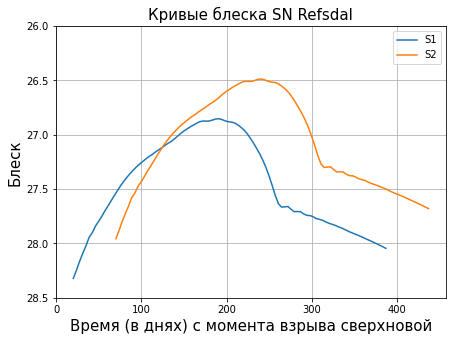

In [192]:
plt.plot(t1_grid, m1, label="S1")
plt.plot(t2_grid, m2, label="S2")

grafik()

# Добавляем микролинзирование

Добавим шум (пока что обычный гауссовый):

In [193]:
microlensing_noise1 = np.random.normal(0., 0.1, len(t1_grid)) #здесь должна быть случайная реализация шума, извлеченного из карт микролинзирования
microlensing_noise2 = np.random.normal(0., 0.1, len(t2_grid)) #десь должна быть другая случайная реализация шума

lc1_noise = m1 + microlensing_noise1
lc2_noise = m2 + microlensing_noise2

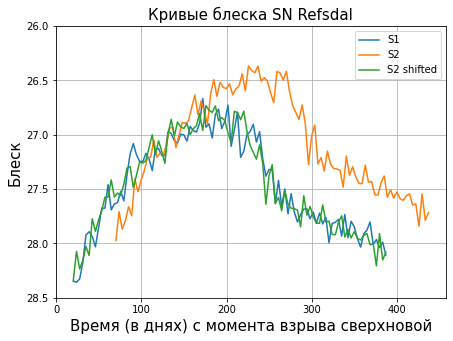

In [194]:
plt.plot(t1_grid, lc1_noise, label="S1")
plt.plot(t2_grid, lc2_noise, label="S2")

lc2_noise_shifted = np.interp(t1_grid + dt_true, t2_grid, lc2_noise) - dm_true

plt.plot(t1_grid, lc2_noise_shifted, label="S2 shifted")

grafik()

In [195]:
#delta_t = np.arange(time_delay-50, time_delay+50, 0.1) # сетка по временным задержкам
#chi2 = delta_t*0.

#N = len(t1_grid) # количество точек
#s = 0.05
#k = dm

#for i in range(len(delta_t)): 

#  new_grid = t2_grid - delta_t[i]

#  lc1_wum_shifted = np.interp(new_grid, t1_grid, lc1_wum)

#  chi2[i] = np.sum( np.abs(lc2_wum - lc1_wum_shifted - k)**2 )/N/s**2

#print(delta_t[np.argmin(chi2)])
#plt.plot(delta_t, chi2)
#plt.show()

# emcee

In [ ]:
! pip install emcee
! pip install corner

Подготовим данные для дальнейшего их использования в emcee:

In [221]:
data = np.zeros((4,100))

for i in range(0,100):
  data[0][i] = t1_grid[i]
  data[1][i] = lc1_noise[i]
  data[2][i] = t2_grid[i]
  data[3][i] = lc2_noise[i]

Зададим необходимые функции. Логика следующая: мы "кормим" алгоритм данными из изображения S2, а потом сравниваем их со сдвинутым по времени и магнитуде изображением S1. Вопрос: 

In [214]:
def model(params, x1, y2, x2):
    dt, dmu = params
    return np.interp(x1 + dt, x2, y2) - dmu

def lnlike(params, x1, y1, x2, y2):
    dt, dmu = params
    lnlike = -0.5 * np.sum( ( (y1 - model(params, x1, y2, x2))/0.05 )**2 )
    return lnlike

def lnprior(params):
    dt, dmu = params
    if (0 < dt < 100 and -5 < dmu < 5):
        return 0.0
    return -np.inf

def lnprob(params, x1, y1, x2, y2):
    lp = lnprior(params)
    if np.isfinite(lp):
      return lp + lnlike(params, x1, y1, x2, y2)
    else:
      return -np.inf

In [247]:
import emcee
import corner

nwalkers = 1000

initial = np.array([47, -2.5*np.log10(1.3)])

ndim = len(initial)

p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)#(t1_grid, lc1_noise, t2_grid, lc2_noise) )

p0, _, _ = sampler.run_mcmc(p0, 100, progress=True)
sampler.reset()

sampler.run_mcmc(p0, 2000, progress=True)

!clear

100%|██████████| 2000/2000 [00:58<00:00, 34.06it/s]


In [246]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: ignored

In [243]:
def plotter(sampler, show_all):

    plt.ion()
    plt.plot(t1_grid, lc1_noise, label='S1')
    plt.plot(t2_grid, lc2_noise, label='S2')

    samples = sampler.flatchain

    if show_all:
      for s in samples[np.random.randint(len(samples), size=50)]:
        plt.plot(t1_grid, model(s, t1_grid, lc2_noise, t2_grid), color="r", alpha=0.1)
    else:
      s  = samples[np.argmax(sampler.flatlnprobability)]
      print('Best dt = {0:.3f}'.format(s[0]) )
      print('Best dmu = {0:.3f}'.format(s[1]) )
      #print('or best magnification ratio = {0:.3f}'. format(10**(-0.4*s[1])) )
      best_fit_model = model(s, t1_grid, lc2_noise, t2_grid)
      plt.plot(t1_grid, best_fit_model, color="r", label='Best fit')
    
    grafik()

True dt = 50.000
True dm = -0.365
Best dt = 48.116
Best dmu = -0.372


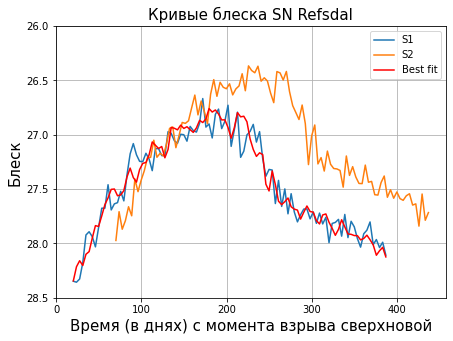

In [244]:
print('True dt = {0:.3f}'.format(dt_true) )
print('True dm = {0:.3f}'.format(dm_true) )

plotter(sampler, show_all=False)

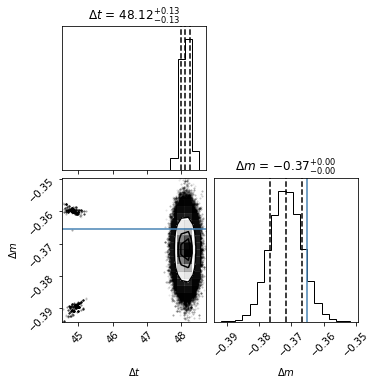

In [245]:
figure = corner.corner(sampler.flatchain, show_titles=True, labels=['$\Delta t$', '$\Delta m$'],  truths=[dt_true, dm_true], quantiles=[0.16, 0.5, 0.84])